<a href="https://colab.research.google.com/github/JKTajo/Data-Analysis-with-Open-Source/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_12%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 12강 정형 데이터 분석 : 서울시 공공 자전거 데이터 활용

### 목표

공공 자전거 이용 특성을 파악하고, 날씨와 자전거 이용량의 상관관계를 분석하여 데이터 기반의 정책 수립에 필요한 인사이트를 도출

### 분석 프로세스 개요

1. 데이터 수집 및 전처리
  - CSV 형태의 데이터 수집
  - 기초 통계량 산출
  - 결측치 처리 및 이상치 제거
  - 날짜/시간 데이터 형식 변환
2. 데이터 분석
  - 시계열 패턴 분석
3. 연계 분석
  - 강수량 데이터와의 연계 분석
  - 상관관계 분석
  - 정책 제언으로 연결

In [4]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache –fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 1 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (10.2 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 117528 files and direct

- 런타임 -> 세션 다시 시작

In [1]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

### 12-1 따릉이 대역 기록 2023-04 업로드 및 압축 해제

- 따릉이 데이터 다운로드
  - [서울 열린데이터 광장](https://data.seoul.go.kr)
  - 검색어 : 따릉이
  - 서울시 따릉이 대여소별 대여/반납 승객수 정보
  - 2023-04 다운로드 후 업로드

In [3]:
!unzip tpss_bcycl_od_statnhm_202304.zip -d tpss_bcycl_od_statnhm_202304

Archive:  tpss_bcycl_od_statnhm_202304.zip
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230430.csv  
  inflating: tpss_bcycl_od_statnhm_202304/__MACOSX/._tpss_bcycl_od_statnhm_20230430.csv  
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230429.csv  
  inflating: tpss_bcycl_od_statnhm_202304/__MACOSX/._tpss_bcycl_od_statnhm_20230429.csv  
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230417.csv  
  inflating: tpss_bcycl_od_statnhm_202304/__MACOSX/._tpss_bcycl_od_statnhm_20230417.csv  
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230418.csv  
  inflating: tpss_bcycl_od_statnhm_202304/__MACOSX/._tpss_bcycl_od_statnhm_20230418.csv  
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230419.csv  
  inflating: tpss_bcycl_od_statnhm_202304/__MACOSX/._tpss_bcycl_od_statnhm_20230419.csv  
  inflating: tpss_bcycl_od_statnhm_202304/tpss_bcycl_od_statnhm_20230420.csv  
  inflating: tpss_bcycl_od_statnh

## 12-2 CSV 형태의 데이터 수집

In [4]:
import glob
import pandas as pd

## CSV 파일 목록 가져오기
all_files = glob.glob("tpss_bcycl_od_statnhm_202304/*.csv")
dataframes = []
for filename in all_files:
    df = pd.read_csv(filename, encoding='cp949', sep=',')
    ## CSV 파일 읽어서 데이터프레임화
    dataframes.append(df)
## 모든 데이터프레임 결합
df = pd.concat(dataframes)
## 상위 5행 출력
df.head(5)

,기준_날짜,집계_기준,기준_시간대,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명,전체_건수,전체_이용_분,전체_이용_거리
0,20230421,출발시간,0,ST-1135,도봉1동_037_1,ST-1135,도봉1동_037_1,1,0,0
1,20230421,출발시간,0,ST-1163,방배4동_043_1,ST-1163,방배4동_043_1,1,0,0
2,20230421,출발시간,0,ST-1660,자양3동_025_1,ST-1660,자양3동_025_1,1,0,0
3,20230421,출발시간,0,ST-737,가락본동_025_1,ST-737,가락본동_025_1,1,0,0
4,20230421,출발시간,5,ST-1842,천호3동_039_1,ST-1842,천호3동_039_1,1,1,0


## 12-3 기초 통계량 산출

In [5]:
import numpy as np
## 수치형 데이터 요약 통계 출력
df.describe(include=[np.number])
## 범주형 데이터 요약 통계 출력
df.describe(include=['object'])

,집계_기준,시작_대여소_ID,시작_대여소명,종료_대여소_ID,종료_대여소명
count,7769469,7769469,7769469,7769469,7737347
unique,2,2729,2733,2730,2732
top,출발시간,ST-2031,가양1동_039_8,X,가양1동_039_8
freq,3897362,27016,27016,32122,28092


## 12-4 결측치 및 이상치 제거

In [6]:
## 결측치 제거
df = df.dropna()
## '전체_이용_분' 컬럼 값 필터링 (1분 이하, 180분 이상 제거)
bike_enhanced = df.copy()
bike_enhanced['is_outliers_time'] = ((bike_enhanced['전체_이용_분']<1) | (bike_enhanced['전체_이용_분'] > 180))
total_outliers_time = bike_enhanced['is_outliers_time'].sum()
total_ratio_time = bike_enhanced['is_outliers_time'].mean()
print(total_outliers_time)
print(total_ratio_time)
## '전체_이용_거리' 컬럼 값 필터링 (10M 이하, 10000M 이상 제거)
bike_enhanced['is_outliers_distance'] = ((bike_enhanced['전체_이용_거리']<10)|(bike_enhanced['전체_이용_거리']>10000))
total_outliers_distance= bike_enhanced['is_outliers_distance'].sum()
total_ratio_distance = bike_enhanced['is_outliers_distance'].mean()
print(total_outliers_distance)
print(total_ratio_distance)




bike_enhanced['is_outliers_any'] = (
    bike_enhanced['is_outliers_time']|
    bike_enhanced['is_outliers_distance']
)
bike_cleaned = bike_enhanced[
    ~bike_enhanced['is_outliers_any']
].copy()
## '집계_기준' 컬럼 필터링 (출발시간만 사용)
bike_cleaned = bike_cleaned[bike_cleaned['집계_기준'] == '출발시간']




229982
0.029723624906573275
667018
0.08620758510636785


## 12-5 날짜/시간 데이터 형식 변환

In [7]:
## '기준_날짜' 컬럼 datetime 형식으로 변환 (%Y%m%d)
bike_cleaned['기준_날짜'] = pd.to_datetime(bike_cleaned['기준_날짜'], format='%Y%m%d')
bike_cleaned.info()
## '요일' 컬럼 생성
day_mapping = {
    'Monday': '월요일',
    'Tuesday': '화요일',
    'Wednesday': '수요일',
    'Thursday': '목요일',
    'Friday': '금요일',
    'Saturday': '토요일',
    'Sunday': '일요일'
}
bike_cleaned['요일'] = bike_cleaned['기준_날짜'].dt.day_name().map(day_mapping)
print(bike_cleaned['요일'])

<class 'pandas.core.frame.DataFrame'>
Index: 3539096 entries, 79 to 208722
Data columns (total 13 columns):
 #   Column                Dtype         
---  ------                -----         
 0   기준_날짜                 datetime64[ns]
 1   집계_기준                 object        
 2   기준_시간대                int64         
 3   시작_대여소_ID             object        
 4   시작_대여소명               object        
 5   종료_대여소_ID             object        
 6   종료_대여소명               object        
 7   전체_건수                 int64         
 8   전체_이용_분               int64         
 9   전체_이용_거리              int64         
 10  is_outliers_time      bool          
 11  is_outliers_distance  bool          
 12  is_outliers_any       bool          
dtypes: bool(3), datetime64[ns](1), int64(4), object(5)
memory usage: 307.1+ MB
79        금요일
101       금요일
109       금요일
176       금요일
185       금요일
         ... 
208670    일요일
208672    일요일
208676    일요일
208677    일요일
208722    일요일
Name: 요일, Length: 3539096, d

## 전처리 결과 확인

In [8]:
## 수치형 데이터 요약 통계 출력
print("수치형 데이터 요약 통계:\n", df.describe().to_markdown())
## 범주형 데이터 요약 통계 출력
print("\n범주형 데이터 요약 통계:\n", df.describe(include=['object']).to_markdown())

수치형 데이터 요약 통계:
 |       |   기준_날짜 |    기준_시간대 |    전체_건수 |   전체_이용_분 |   전체_이용_거리 |
|:------|------------:|---------------:|-------------:|---------------:|-----------------:|
| count | 7.73735e+06 |    7.73735e+06 |  7.73735e+06 |    7.73735e+06 |      7.73735e+06 |
| mean  | 2.02304e+07 | 1451.3         |  1.07541     |   22.8454      |   2715.5         |
| std   | 8.52132     |  561.267       |  0.309813    |   31.4494      |  11975.4         |
| min   | 2.02304e+07 |    0           |  1           |    0           |      0           |
| 25%   | 2.02304e+07 | 1020           |  1           |    6           |    860           |
| 50%   | 2.02304e+07 | 1600           |  1           |   12           |   1560           |
| 75%   | 2.02304e+07 | 1855           |  1           |   27           |   3001           |
| max   | 2.02304e+07 | 2355           | 17           | 2001           |      1.29444e+07 |

범주형 데이터 요약 통계:
 |        | 집계_기준   | 시작_대여소_ID   | 시작_대여소명   | 종료_대여소_ID   | 종료_대여소명   

# 2. 데이터 분석

## 12-6 요일별 이용량 분석

In [9]:
## 요일별 이용량 계산 및 정렬
day_df = bike_cleaned['요일'].value_counts().reindex(day_mapping.values())

## day_df = bike_cleaned.groupby('요일')['전체_이용_거리'].sum().reset_index().sort_values(by='요일', ascending=True)

## 요일별 이용량 출력
print("요일별 이용량:\n", day_df)

요일별 이용량:
 요일
월요일    599430
화요일    396395
수요일    450641
목요일    483560
금요일    579407
토요일    497912
일요일    531751
Name: count, dtype: int64


## 12-7 요일별 이용량 시각화

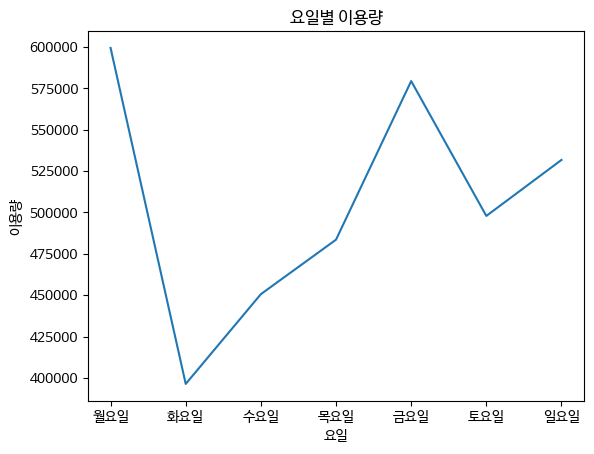

In [10]:
import matplotlib.pyplot as plt

## 요일별 이용량 막대 그래프 생성
plt.plot(day_df)
plt.title('요일별 이용량')
plt.xlabel('요일')
plt.ylabel('이용량')
plt.show()

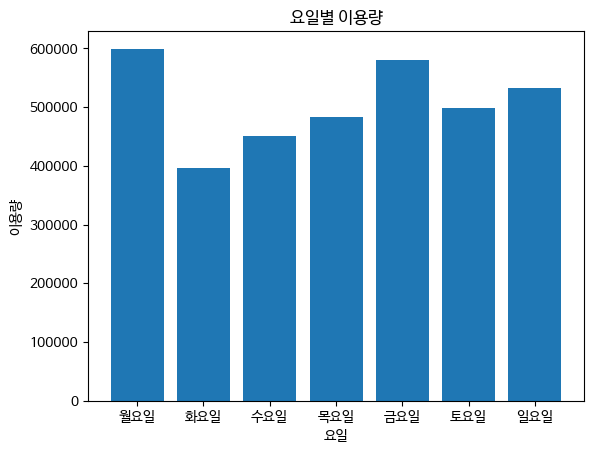

In [11]:
## Dataframe의 plot을 이용한 요일별 이용량 막대 그래프 생성
## 데이터 정의
# categories = day_df['요일']
# values = day_df['이용량']

## 막대 그래프 그리기
# plt.bar(categories, values, width=0.5, color='green')
plt.bar(day_df.index, day_df.values)
plt.title('요일별 이용량')
plt.xlabel('요일')
plt.ylabel('이용량')
plt.show()

## 12-8 시간별 이용량 분석 및 시각화

시간별 이용량:
 기준_시간대
0      77872
1      54139
2      34604
3      22677
4      17559
5      29651
6      65311
7     168190
8     256676
9     153080
10    119633
11    138833
12    156381
13    160404
14    169002
15    192128
16    237939
17    304548
18    365659
19    234104
20    185962
21    172160
22    147380
23     75204
Name: count, dtype: int64


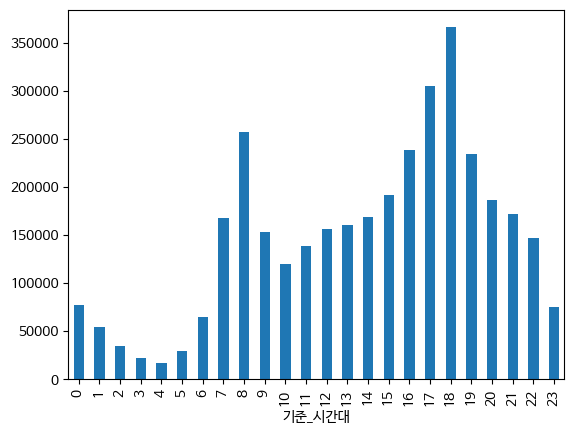

In [14]:
## '출발_시' 컬럼 생성 (기준_시간대 // 100)
day_df['출발_시'] = bike_cleaned['기준_시간대'] // 100
## 시간별 이용량 계산 및 정렬 (hour_df로 저장)
hour_df = day_df['출발_시'].value_counts().sort_index()
## 시간별 이용량 출력
print("시간별 이용량:\n", hour_df)

## 시간별 이용량 막대 그래프 생성
hour_df.plot(kind='bar')
plt.show()

## 12-9 일자별 이용량 분석 및 시각화

일자별 이용량:
 기준_날짜
20230401    299257
20230402    296871
20230403    343775
20230404    266175
20230405     46063
20230406    123907
20230407    274843
20230408    244114
20230409    237739
20230410    316250
20230411    206556
20230412    280359
20230413    289178
20230414    321408
20230415    182015
20230416    208076
20230417    312042
20230418    207930
20230419    348545
20230420    292839
20230421    340466
20230422    287036
20230423    253833
20230424    330307
20230425    172162
20230426    298556
20230427    336261
20230428    318898
20230429     96054
20230430    205832
Name: count, dtype: int64


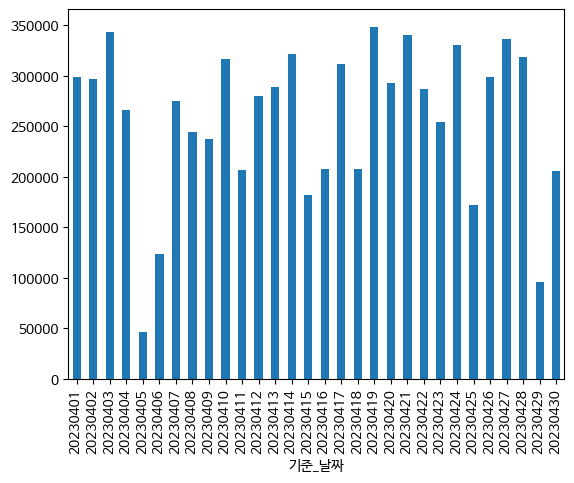

In [13]:
## 일자별 이용량 계산 및 정렬
daily_usage_df = df['기준_날짜'].value_counts().sort_index()
## 일자별 이용량 출력
print("일자별 이용량:\n", daily_usage_df)

## 일자별 이용량 막대 그래프 생성
daily_usage_df.plot(kind='bar')
plt.show()

# 3. 연계 분석

- 기상청 기상자료개방포탈 자료 수집
  - 기후통계분석 > 통계분석 > 조건별통계
  - https://data.kma.go.kr/climate/RankState/selectRankStatisticsDivisionList.do?pgmNo=179
  - 지역/지점 : 서울
  - 요소 : 강수량
  - 기간 : 일, 2023년 ~ 2023년
  - 조건 : 04월, 01 ~ 31일
- 다운로드 후 파일명 `seoul_rain_2023_04.csv`로 변경하여 colab에 업로드

## 12-10 강수량 데이터 로드

In [15]:
## 강수량 데이터 CSV 파일 로드
file_path = 'seoul_rain_2023_04.csv'
rain_df = pd.read_csv(file_path, encoding='cp949', skiprows=12)
rain_df.head(5)
rain_df.columns

Index(['\t지점번호', '지점명', '일시', '강수량(mm)', '1시간최다강수량(mm)', '1시간최다강수량시각',
       'Unnamed: 6'],
      dtype='object')

## 12-11 강수량 데이터 전처리

In [16]:
## '일시' 컬럼 datetime 형식으로 변환
rain_df['일시'] = pd.to_datetime(rain_df['일시'], format='%Y-%m-%d')
## '강수량(mm)' 컬럼 결측치 0으로 채우기
rain_df['강수량(mm)'] = rain_df['강수량(mm)'].fillna(0)
## 불필요한 컬럼 제거
rain_df.drop(columns=['\t지점번호', 'Unnamed: 6'], inplace=True)

## 12-12 일자별 이용량 데이터와 강수량 데이터 병합

In [20]:
## 일자별 이용량과 강수량 데이터 병합 (daily_usage_gf의 기준_날짜, rain_df의 일시를 기준으로 결합)
merged_df = pd.merge(
    daily_usage_df, rain_df,
    how='left',
    left_on='기준_날짜',
    right_on='일시'
)
## 'count' 컬럼명 '이용량'으로 변경
merged_df.rename(columns={'count': '이용량'}, inplace=True)
## 병합된 데이터프레임 상위 5행 출력
merged_df.head(5)

ValueError: You are trying to merge on int64 and datetime64[ns] columns for key '기준_날짜'. If you wish to proceed you should use pd.concat

## 12-13 이용량 및 강수량 시각화

NameError: name 'merged_df' is not defined

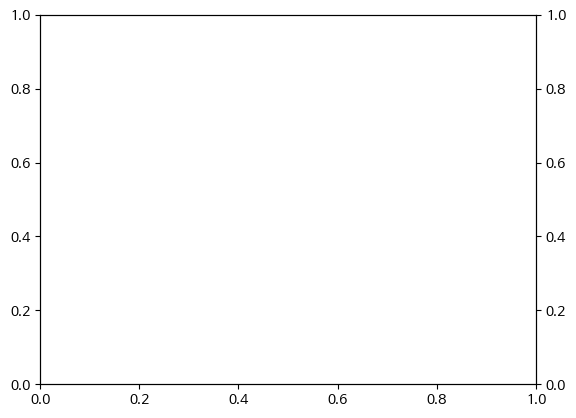

In [21]:
## 두 개의 y축을 가진 서브플롯 생성
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() ## 두 번째 y축 생성

## 첫 번째 y축에 이용량 막대 그래프 그리기
ax1.bar(merged_df['일시'], merged_df['이용량'],color='b')
## 두 번째 y축에 강수량 꺾은선 그래프 그리기
ax2.plt(merged_df['일시'], merged_df['강수량(mm)'],color='r')

## x축 및 y축 레이블 설정
ax1.set_xlabel('날짜')
ax1.set_ylabel('이용량', color='b')
ax2.set_ylabel('강수량(mm)', color='r')

## 그래프 표시
plt.show()

## 12-14 강수량과 이용량 상관관계 분석

In [ ]:
import seaborn as sns ## seaborn 라이브러리 임포트

## 강수량이 있는 날만 필터링
merged_onlyrain_df = merged_df[merged_df['강수량(mm)'] > 0]
## 강수량과 이용량의 상관계수 계산
corr = merged_onlyrain_df['이용량'].corr(merged_onlyrain_df['강수량(mm)'])
## 상관계수 출력
print("강수량과 이용량의 상관계수:", corr)

## 강수량과 이용량의 회귀선 그래프 생성


## y축 범위 설정
plt.ylim(0, merged_onlyrain_df['이용량'].max()*1.1)

## 그래프 제목 및 축 레이블 설정
plt.title(f'강수량과 이용량 상관관계 (r = {corr:.2f})')
plt.xlabel('강수량 (mm)')
plt.ylabel('이용 건수')
## 그래프 표시
plt.show()

## 12-15 OLS 회귀 모델 생성 및 분석 및 귀무가설 검증

In [ ]:
import statsmodels.formula.api as smf ## statsmodels.formula.api 임포트

## 컬럼명 변경: '강수량(mm)' -> '강수량_mm' (formula API 호환을 위해)
merged_onlyrain_df = merged_onlyrain_df.copy()
merged_onlyrain_df.rename(columns={'강수량(mm)': '강수량_mm'}, inplace=True)

## OLS 모델 정의 및 학습

results = model.fit()

## 모델 요약 결과 출력
print(results.summary())

## 귀무가설 검증 해석
## 강수량_mm 계수에 대한 p-value를 확인하여 귀무가설 (강수량이 이용량에 미치는 영향이 0이다) 검증
## 일반적으로 p-value가 0.05 미만이면 귀무가설을 기각하고 유의미한 영향이 있다고 해석
print("\n--- 귀무가설 검증 (강수량 계수) ---")
p_value = results.pvalues['강수량_mm']
print(f"강수량_mm 계수의 p-value: {p_value:.4f}")
if p_value < 0.05:
    print("p-value가 0.05보다 작으므로 귀무가설을 기각합니다.")
    print("즉, 강수량은 자전거 이용량에 통계적으로 유의미한 영향을 미칩니다.")
else:
    print("p-value가 0.05보다 크므로 귀무가설을 기각할 수 없습니다.")
    print("즉, 강수량은 자전거 이용량에 통계적으로 유의미한 영향을 미치지 않는다고 볼 수 있습니다.")